<a href="https://colab.research.google.com/github/FrankGangWang/AppliedML_Python_Coursera/blob/master/Copy_of_Final_Interview_for_DataScience_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Interview questions to test data science skills**

---




# Let's load the data from public GitHub account

In [ ]:
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt

# load data and check condation of NA
df = pd.read_pickle("https://github.com/manjiler/interview_for_datascience/raw/master/interview_storage.pkl")
df['timestamp_seconds'] = df.pop('timestamp')/1.0e3

# add sorted datetime index
df.set_index(pd.to_datetime(df['timestamp_seconds'], unit='s', origin='unix'), inplace=True)
df.sort_index(inplace=True)

# Constants
SYSTEM_ID_SELECTED = ['sys1'] #['All']
TEST_SIZE = 0.2 # Not yet used
# NOTE: As PowerTransform only accept positive inputs thus separately process transformed times
USE_TIME_TRANSFORMED = True 
USE_TIME_STAMP = True

# We separately process sub-sets of columns and concatenate them in a numpy array called data 
target_col = ['cpu_utilization']
numerical_transform_cols = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
                            'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz']
time_col = ['timestamp_seconds']
time_transformed_cols = ['Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos']
cols_to_encode = ['systemId', 'model_type']

#AS timestamp_seconds is appended after numerical_transform_cols are added to data
# As feature selection can be RFE thus standarize/normalize data first;
# Feature selection also cause time poition dymanic thus need be decided after all feature selection
TIMESTAMP_INDEX_BEFORE_FS = len(target_col) + len(time_col) + len(numerical_transform_cols) - 1 

Y_INDEX_DATA = 0 # index of target in data
X_FIRST_INDEX_DATA = 1 # first index in data for X

hour = 60*60
day = 24*hour
week = 7*day

data_cols = []

In [ ]:
print(df[df['systemId']==SYSTEM_ID_SELECTED[0]].loc[:, ['systemId', 'model_type', 'cpu_utilization']] .head(5))
print(df[df['systemId']==SYSTEM_ID_SELECTED[0]].loc[:, ['systemId', 'model_type', 'cpu_utilization']] .tail(5))


                    systemId model_type  cpu_utilization
timestamp_seconds                                       
2019-11-01 04:25:00     sys1          A        23.083557
2019-11-01 04:30:00     sys1          A        18.258795
2019-11-01 04:35:00     sys1          A        17.899469
2019-11-01 04:40:00     sys1          A        20.296371
2019-11-01 04:45:00     sys1          A        18.300312
                    systemId model_type  cpu_utilization
timestamp_seconds                                       
2019-11-30 23:35:00     sys1          A        24.737446
2019-11-30 23:40:00     sys1          A        19.898367
2019-11-30 23:45:00     sys1          A        22.392872
2019-11-30 23:50:00     sys1          A        24.213583
2019-11-30 23:55:00     sys1          A        18.350607


In [ ]:
# check missing data; result: no missing data
print(f'*** There are {df.isna().sum().sum()} NA data')
df.describe()

## Now that the data is loaded. let's begin!!!

# **About the data**

---
This is time series data for one month collected for N number of devices

Columns

systemId - Device name

timestamp_seconds - epoch time when the sensor data was collected

model_type - Different versions/release/model of the device (similar to mobile models)

cpu_utilization - this percentage of how much the CPU is used on the device.

read_cache_miss - Percentage of read that were not present in the Cache

write_cache_miss - Percentage of write that were not present in the Cache

read_iops -  Number of read IOs per second (Input/Output)

write_iops -  Nummber of write IOs per second (Input/Output)

read_throughput - the read bandwidth per second (Units kbps)

write_throughput - the write bandwidth per second (Units kbps)

read_iosz - the block size for read Input/Output operations

write_iosz - the block size for write Input/Output operations


y -> cpu_utilization



## Q1. Do an EDA on the data, correlation plots, features that might be important for the modeling. Share your observations. Comment on how the data looks from modeling perspective

In [ ]:
# plot utilities
# plot histogram of systemId_selected
def plot_df_hist(df_tmp, systemId_selected, title_str, cols, bins):
  if systemId_selected[0] != 'All':
    df_tmp = df_tmp[df_tmp['systemId']==systemId_selected[0]]
  df_tmp = df_tmp[cols]
  df_tmp.hist(bins=bins)
  fig = plt.gcf()
  fig.set_size_inches(18, 8)
  fig.suptitle(f'{title_str}, systemId {systemId_selected[0]}')
  plt.tight_layout()
  fig.subplots_adjust(top=0.9)

# utility hist2d plot xcols against target ycol
def hist2d_plot(df_temp, systemId, xcols, ycol, xbins, ybins, vmax):
  print(f"hist2d_plot 1 Initial address of df_temp: {id(df_temp)}, shape={df_temp.shape}")
  if systemId != 'All': 
    df_temp = df[df['systemId']==systemId[0]]
  print(f"hist2d_plot 2 Initial address of df_temp: {id(df_temp)}, shape={df_temp.shape}")
  print(df_temp.shape)
  len_x = len(xcols)
  num_rows = math.ceil(math.sqrt(len_x))
  num_cols = math.ceil(len_x/num_rows)
  x_index = 0
  for row in range(num_rows):
    for col in range(num_cols):
      if x_index == len_x:
        break
      plt.subplot(num_rows, num_cols, x_index+1)
      plt.hist2d(df_temp[xcols[x_index]], df_temp[ycol], bins=[xbins, ybins], vmax=vmax) #
      plt.colorbar()
      plt.xlabel(xcols[x_index])
      plt.ylabel(ycol)
      x_index = x_index + 1
  fig = plt.gcf()
  fig.set_size_inches(18.5, 3*num_rows)
  fig.suptitle(f'systemId={systemId}')
  plt.tight_layout() # 2nd last step in fig setting
  fig.subplots_adjust(top=0.88) # last in fig setting
  plt.show()


In [ ]:
# add some artificial features maybe useful for classification
# add sin/cos for day/hour
# To help finding time periodicity (hourly/daily/weekly/monthly/yearly), 
#    add additional features like "time of day/week" by appling cos and sin to timestamp_seconds 
df['Hour_Sin'] = np.sin(df['timestamp_seconds'] * (2 * np.pi / hour))
df['Hour_Cos'] = np.cos(df['timestamp_seconds'] * (2 * np.pi / hour))
df['Day_Sin'] = np.sin(df['timestamp_seconds'] * (2 * np.pi / day))
df['Day_Cos'] = np.cos(df['timestamp_seconds'] * (2 * np.pi / day))
week_offset = 3*day # as epoch 0 is Thursday 1970-01-01, and leap seconds 23:59:60
df['Week_Sin'] = np.sin((df['timestamp_seconds']+week_offset) * (2 * np.pi / week))
df['Week_Cos'] = np.cos((df['timestamp_seconds']+week_offset) * (2 * np.pi / week))

In [ ]:
# RUN: plot hist
# Conclusion: a few columns are far from Gaussian distribution
title_str = 'Before transformation!'
plot_df_hist(df, SYSTEM_ID_SELECTED, title_str, df.columns, 30)
#NOTE: Hour_Sin AND Hour_Cos have only 7 distinct bins at [0, 30, 60, 90, -30, -60, -90] degress as 
# as sampling perid=5 minutes, thus 2pi*5min/60min=pi/6=30degree

The histograms show that we need apply normalization and power transformation


In [ ]:
#Plot hist2d: xcols against target ycol
vmax = 100; xbins = 50; ybins = 50
ycol = 'cpu_utilization'
xcols_group = [
  ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops'],
  ['read_throughput', 'write_throughput', 'read_iosz', 'write_iosz'],
  ['Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos']]
for xcols in xcols_group:
  hist2d_plot(df, SYSTEM_ID_SELECTED, xcols, ycol, xbins, ybins, vmax)

In [ ]:
df.columns


In [ ]:
# All pre-processing functions
# Transform to make data more Gaussian-like 
# Standarize to make close Norml(0, 1)
# Only to numerical_transform_cols, not for timestamp, categoricals
def get_target_for_transform(df, systemId_selected, numerical_transform_cols, print_flag=False):
  from sklearn.preprocessing import PowerTransformer
  #from sklearn.preprocessing import QuantileTransformer
  if systemId_selected[0] == 'All':
    df_tmp = df[numerical_transform_cols]
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]
  if print_flag:
    print(f'*** Inside get_target_for_transform(): df_tmp.shape={df_tmp.shape}')
  # Start Transformation
  data = df_tmp.values
  return data

# Transform to make data more Gaussian-like 
# Standarize to make close Norml(0, 1)
# Only to numerical_transform_cols, not for timestamp, categoricals
def transform_features(df, systemId_selected, numerical_transform_cols, print_flag=False):
  from sklearn.preprocessing import PowerTransformer
  #from sklearn.preprocessing import QuantileTransformer
  if systemId_selected[0] == 'All':
    df_tmp = df[numerical_transform_cols]
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]
  # Start Transformation
  data = df_tmp.values
  power = PowerTransformer(method='box-cox', standardize=True)
  data = power.fit_transform(data)
  if print_flag:
    print(f'*** Inside transform_features(): df_tmp.shape={df_tmp.shape}')
    print(f'  transform_features: {power.get_params(deep=True)}')
    print(f'  power.lambdas_: {power.lambdas_}')
  return data, power

# RUN: LabelEncoder + OneHotEncoder for categorical columns
# return np.array oflabel encoded data and encoders
def label_encode(df_in, systemId_selected, cols_to_encode, print_flag=False):
  from sklearn.preprocessing import LabelEncoder
  from sklearn.preprocessing import OneHotEncoder
  if systemId_selected[0] == 'All':
    df = df_in
  else:  
    df = df_in[df_in['systemId']==systemId_selected[0]]
  print(f'inside label_encode: systemId={systemId_selected}, df shape={df.shape}')
  first_col = True
  label_encoders = []
  my_onehot_encoders = []
  for col in cols_to_encode:
    label_encoder = LabelEncoder()
    X = df[col].values
    X = label_encoder.fit_transform(X)
    label_encoders.append({col:label_encoder})
    X = X.reshape(X.shape[0], 1)
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    X = onehot_encoder.fit_transform(X)
    if print_flag:
      print(f'******Inside label_encode: just after my_OneHotEncoder: col={col}, X.shape={X.shape}')
      print(f'******Inside label_encode: just after my_OneHotEncoder: col={col}, onehot_encoder={onehot_encoder}')
    if first_col:
      data = X
      #print(f'first_col={first_col}, col={col}, X.shape={X.shape}, data.shape={data.shape}')
      first_col = False
    else:        
      data = np.concatenate((data, X), axis=1)
      #print(f'first_col={first_col}, col={col}, X.shape={X.shape}, data.shape={data.shape}')
  return data, label_encoders, my_onehot_encoders 

def minmax_scaler_time(df, systemId_selected, cols):
  from sklearn.preprocessing import MinMaxScaler
  if systemId_selected[0] == 'All':
    df_tmp = df[cols].values
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][cols].values
  minmax_scaler = MinMaxScaler()
  df_tmp = minmax_scaler.fit_transform(df_tmp)
  return df_tmp

Compare hists of each single systemId ('sys1' vs 'sys2', etc) and single systemId with hist of all systemIds 'All' case:
1. each systemId has different hist patterns
2. Hour_Sin and Hour_Cos show a pattern at certain times per hour


In [ ]:
print(df.columns.shape, '\n', df.columns)


(18,) 
 Index(['systemId', 'model_type', 'cpu_utilization', 'read_cache_miss',
       'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput',
       'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds',
       'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Week_Sin', 'Week_Cos'],
      dtype='object')


In [ ]:
# Step 1: transform AND standarization FOR numerical_transform_cols
# Step 1.1: transform target Y
# MUST first use numerical_transform_cols THEN use cols_to_encode
# MUST NOT transform timestamp_seconds !!! 
from sklearn.preprocessing import PowerTransformer

data_cols = []
data = get_target_for_transform(df, SYSTEM_ID_SELECTED, target_col)
target_transformer = PowerTransformer(method='box-cox', standardize=True)
data = target_transformer.fit_transform(data)
data_cols = data_cols + target_col

print(f'After Y PowerTransformer, data shape={data.shape}, target_col len = {len(target_col)}, data_cols={len(data_cols)}')
print(f'  target_transformer.get_params = : {target_transformer.get_params(deep=True)}')
print(f'  target_transformer.lambdas_= {target_transformer.lambdas_}')

# Step 1.2: transform AND standarization FOR numerical_transform_cols
# MUST first use numerical_transform_cols THEN use cols_to_encode
# MUST NOT transform timestamp_seconds !!! 

print(f'Before X numericals transformation:')
print(f'  data shape = {data.shape}')
print(f'  len of numerical_transform_cols = {len(numerical_transform_cols)}')
data_new, numerical_X_transformer = transform_features(df, SYSTEM_ID_SELECTED, numerical_transform_cols)
data_cols = data_cols + numerical_transform_cols
data = np.concatenate((data, data_new), axis=1)
print(f'After X numericals transformation:')
print(f'  data shape={data.shape}')
print(f'  data_cols len={len(data_cols)},\n  data_cols={data_cols}')


# process timestamp_seconds
if USE_TIME_STAMP:
  print(f'Before add new column {time_col}:\n  data shape={data.shape},\n  len time_col={len(time_col)}')
  data_new = minmax_scaler_time(df, SYSTEM_ID_SELECTED, time_col)
  data_cols = data_cols + time_col
  data = np.concatenate((data, data_new), axis=1)
  print(f'After add {time_col}:\n  data shape={data.shape},\n  len data_cols={len(data_cols)}')

# RUN: MinMax timestamp_seconds, not StandardScaler
# timestamp_seconds will be mapped to data[:,9] AND X[:,8]
if USE_TIME_TRANSFORMED:
  data_cols = data_cols + time_transformed_cols
  data_new = minmax_scaler_time(df, SYSTEM_ID_SELECTED, time_transformed_cols)
  print(f'Before add {len(time_transformed_cols)} columns {time_transformed_cols}:\n  data shape={data.shape},\n  data_new shape={data_new.shape}')
  data = np.concatenate((data, data_new), axis=1)
  print(f'After add time_transformed_cols:\n  data shape={data.shape},\n  data_cols ={data_cols}')


# Add label encoder categorical columns (model_type only) (sysemId)
# Note: This is only useful is model all systemIds together;
# WARNING: only run once to avoid add the same columns more than 1 times

data_new, label_encoders, my_onehot_encoders = label_encode(df, SYSTEM_ID_SELECTED, cols_to_encode)
print(f'Before add {len(cols_to_encode)} columns {cols_to_encode}:\n  data shape={data.shape},\n  data_new shape={data_new.shape}')
data = np.concatenate((data, data_new), axis=1)
data_cols = data_cols + cols_to_encode

print(f'After concatenate:\n  data shape={data.shape}')
print(f'  data_cols len={len(data_cols)},\n  data_cols={data_cols}')




After Y PowerTransformer, data shape=(7926, 1), target_col len = 1, data_cols=1
  target_transformer.get_params = : {'copy': True, 'method': 'box-cox', 'standardize': True}
  target_transformer.lambdas_= [0.07711959]
Before X numericals transformation:
  data shape = (7926, 1)
  len of numerical_transform_cols = 8
After X numericals transformation:
  data shape=(7926, 9)
  data_cols len=9,
  data_cols=['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz']
Before add new column ['timestamp_seconds']:
  data shape=(7926, 9),
  len time_col=1
After add ['timestamp_seconds']:
  data shape=(7926, 10),
  len data_cols=10
Before add 6 columns ['Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos']:
  data shape=(7926, 10),
  data_new shape=(7926, 6)
After add time_transformed_cols:
  data shape=(7926, 16),
  data_cols =['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read

In [ ]:
print(data.shape, len(data_cols), data_cols)

(7926, 18) 18 ['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds', 'Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos', 'systemId', 'model_type']


After add ['timestamp_seconds']:
  data shape=(7926, 18),
  len data_cols=18


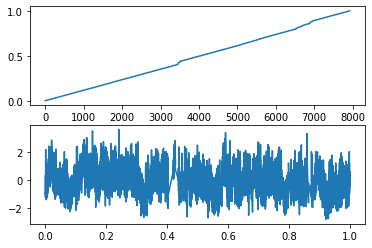

In [ ]:
print(f'After add {time_col}:\n  data shape={data.shape},\n  len data_cols={len(data_cols)}')
plt.subplot(2,1,1)
plt.plot(data[:, TIMESTAMP_INDEX_BEFORE_FS])
plt.subplot(2,1,2)
plt.plot(data[:, TIMESTAMP_INDEX_BEFORE_FS], data[:, 0])


In [ ]:
# check time transformations are all right
plt.figure()
index_to_plots = [1,3,5,7,8]
L = len(index_to_plots)
for k in range(L):
  plt.subplot(L,1,k+1)
  plt.plot(data[:, TIMESTAMP_INDEX_BEFORE_FS], data[:, TIMESTAMP_INDEX_BEFORE_FS + index_to_plots[k]],)


In [ ]:
# Compare hist before/after transformation/scaling 
# Before transformation: hist
title_str = 'Before transformation!'
plot_df_hist(df, SYSTEM_ID_SELECTED, title_str, df.columns, 30)
#NOTE: Hour_Sin AND Hour_Cos have only 7 distinct bins at [0, 30, 60, 90, -30, -60, -90] degress as 
# as sampling perid=5 minutes, thus 2pi*5min/60min=pi/6=30degree

# After transformation: hist
title_str = 'After transformation!'
data_df = pd.DataFrame(data, columns=data_cols)
plot_df_hist(data_df, ['All'], title_str, data_df.columns, 30)
del data_df

Feature selection:
1. correlation based
2. L1 norm
3. p-value

In [ ]:
# set X, Y, x_cols
X = data[:, X_FIRST_INDEX_DATA:]
Y = data[:, Y_INDEX_DATA]
data_cols
x_cols = data_cols[1:]

print(f' data_cols = {data_cols}, \n x_cols = {x_cols}' )
print(f' data.shape = {data.shape}, len(data_cols) = {len(data_cols)}')
print(f' X.shape = {X.shape}, Y.shape = {Y.shape}')

 data_cols = ['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds', 'Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos', 'systemId', 'model_type'], 
 x_cols = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds', 'Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos', 'systemId', 'model_type']
 data.shape = (7926, 18), len(data_cols) = 18
 X.shape = (7926, 17), Y.shape = (7926,)


In [ ]:
# RUN: feature selection based on correlation  
# NOTE: this is done separately for each of systemId, not for all systemIds altogether
#label encoder for model
def select_feature_by_correlation(data, data_cols, target_col, corr_threshold):
  df = pd.DataFrame(data, columns=data_cols)
  #del df[target_col[0]]
  corr = df.corr()
  columns = np.full((corr.shape[0],), True, dtype=bool)
  for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
      if corr.iloc[i,j] >= corr_threshold:
        columns[j] = False
  selected_columns = df.columns[columns]
  removed_columns = [x for x in df.columns if x not in selected_columns]

  print(f'df shape={df.shape}; corr shape={corr.shape};')
  print(f'df.columns={df.columns}')
  print(f'columns={columns}')
  print(f'selected_columns={selected_columns}')
  print(f'removed_columns={removed_columns}')
  return selected_columns, removed_columns, corr



In [ ]:
# RUN: feature selection based on correlation  
CORR_THRESHOLD_FEATURE_SELECTION = 0.8;
pd.set_option('display.max_columns', None)

#corr_X
selected_columns, removed_columns, corr_X = select_feature_by_correlation(X, x_cols, target_col, CORR_THRESHOLD_FEATURE_SELECTION)    


In [ ]:
# corr_data
_, _, corr_data = select_feature_by_correlation(data, data_cols, target_col, CORR_THRESHOLD_FEATURE_SELECTION)    

In [ ]:
corr_X

In [ ]:
# plot 'read_throughput', 'read_cache_miss'
cols_correlated = ['read_throughput', 'read_cache_miss', 'read_iops', 'write_iops']
cols_correlated_index = [data_cols.index(x) for x in cols_correlated]

print(len(data_cols), data.shape)
print(cols_correlated_index, data_cols)
plt.figure()
plt.plot(data[:, cols_correlated_index[0]], data[:, cols_correlated_index[1]], '+')

plt.figure()
plt.plot(data[:, cols_correlated_index[0]], data[:, cols_correlated_index[2]], '+')

plt.figure()
plt.plot(data[:, cols_correlated_index[0]], data[:, cols_correlated_index[3]], '+')

plt.figure()
plt.plot(data[:, cols_correlated_index[2]], data[:, cols_correlated_index[3]], '+')


In [ ]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())


In [ ]:
# make a regression prediction with an RFE pipeline
# Observation: Features are selected almost according to their correlation with target
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
# create pipeline
for num_features in range(2,17):
  rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=num_features)
  #model = DecisionTreeRegressor()
  #pipeline = Pipeline(steps=[('s',rfe),('m',model)])
  # fit the model on all available data
  #pipeline.fit(X, Y)
  rfe.fit(X, Y)
  scores = rfe.score(X, Y)
  selected_features = rfe.get_support(indices=True)
  print(num_features, selected_features, scores)
  selected_feature_str = [x_cols[x] for x in selected_features]
  print(f'  {selected_feature_str}')
  print(f"  {corr_data.loc[selected_feature_str, target_col[0]]}")

# make a prediction for one example
#data = [[-2.02220122,0.31563495,0.82797464,-0.30620401,0.16003707,-1.44411381,0.87616892,-0.50446586,0.23009474,0.76201118]]
#yhat = pipeline.predict(data)
#print('Predicted: %.3f' % (yhat))

In [ ]:
corr['cpu_utilization']
corr.loc[['read_iops', 'read_throughput'], 'cpu_utilization']


read_iops          0.388049
read_throughput    0.522006
Name: cpu_utilization, dtype: float64

In [ ]:
print(col_new.shape)
print(rfe.get_support(indices=False))
print(rfe.get_support(indices=True))


(7926, 5)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [ ]:
# Start RFE feature selection; 
# Input: X, Y, num_features_to_select

num_features_to_select = [12,13]
# evaluate RFE for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold


# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(num_features_to_select[0], num_features_to_select[1]):
		rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=i)
		model = DecisionTreeRegressor()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

#>>> pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
  #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  kfold = KFold(n_splits = NUM_SPLITS) # shuffle=False
  scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', 
                           cv=kfold, n_jobs=-1, error_score='raise')
  return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model, X, Y)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
  #print(model.support_, model.ranking_)
  print(model)
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()




Observation:
1. read_throughput and read_cache_miss are highly correlated (0.862791);
2. model_type and systemId are unrelated in case of single case systemId
3. timestamps not contribute much
4. transfomred times have some correlation with a few columns



In [ ]:
removed_columns = removed_columns + ['model_type', 'systemId']
removed_columns

['read_throughput', 'model_type', 'systemId']

In [ ]:
def remove_data_columns(data, data_cols, removed_columns):
  data_index_remove = [data_cols.index(x) for x in removed_columns]
  print(f'data_index_remove = {data_index_remove}')
  data = np.delete(data, data_index_remove, axis=1)
  data_cols_updated = [ x for x in data_cols if x not in removed_columns]
  print(data.shape, len(data_cols_updated), data_cols_updated)
  return data_cols_updated, data  


In [ ]:
# WARNING: only run this ONCE
data_cols, data = remove_data_columns(data, data_cols, removed_columns)
TIMESTAMP_INDEX_AFTER_FS = data_cols.index('timestamp_seconds')

data_index_remove = [5, 17, 16]
(7926, 15) 15 ['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds', 'Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos']


In [ ]:
# After all feature selections are done: get timestamp index in data
TIMESTAMP_INDEX_AFTER_FS = data_cols.index('timestamp_seconds')
print(data.shape, len(data_cols) )


(7926, 15) 15


X shape=(7926, 17), Y shape = (7926,)
Epoch 1/20
72/72 [==============================] - 1s 2ms/step - loss: 0.9987
Epoch 2/20
72/72 [==============================] - 0s 2ms/step - loss: 0.4775
Epoch 3/20
72/72 [==============================] - 0s 2ms/step - loss: 0.0738
Epoch 4/20
72/72 [==============================] - 0s 2ms/step - loss: 0.0591
Epoch 5/20
72/72 [==============================] - 0s 2ms/step - loss: 0.0579
Epoch 6/20
72/72 [==============================] - 0s 2ms/step - loss: 0.0565
Epoch 7/20
72/72 [==============================] - 0s 1ms/step - loss: 0.0549
Epoch 8/20
72/72 [==============================] - 0s 2ms/step - loss: 0.0537
Epoch 9/20
72/72 [==============================] - 0s 1ms/step - loss: 0.0556
Epoch 10/20
72/72 [==============================] - 0s 1ms/step - loss: 0.0545
Epoch 11/20
72/72 [==============================] - 0s 1ms/step - loss: 0.0547
Epoch 12/20
72/72 [==============================] - 0s 1ms/step - loss: 0.0557
Epoch 13/20

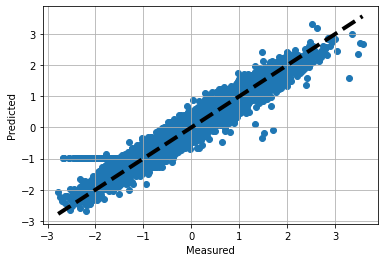

In [ ]:
NUM_SPLITS = 10
NUM_EPOCHS = 20
BATCH_SIZE = 100

# Regression
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

X = data[:, X_FIRST_INDEX_DATA:]
Y = data[:, Y_INDEX_DATA]

# define base model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(18, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
	model.add(Dense(8, kernel_initializer='normal', activation='relu'))
	model.add(Dense(8, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model
  
# Step: evaluate model with standardized dataset
estimators = []
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=1)))
pipeline = Pipeline(estimators)

kfold = KFold(n_splits = NUM_SPLITS) # shuffle=False
#results = cross_val_score(pipeline, X, Y, cv=kfold)
print(f'X shape={X.shape}, Y shape = {Y.shape}')
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))
print(results)

from sklearn.model_selection import cross_val_predict
# TRY this also
#from sklearn import linear_model

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(pipeline, X, Y, cv=kfold)
fig, ax = plt.subplots()
ax.scatter(Y, predicted)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid()
plt.show()


In [ ]:
print(data.shape, X.shape, Y.shape, type(X))
plt.plot(data[:, TIMESTAMP_INDEX_BEFORE_FS], label='TIMESTAMP_INDEX_BEFORE_FS')
plt.plot(data[:, TIMESTAMP_INDEX_AFTER_FS], label='TIMESTAMP_INDEX_AFTER_FS')
ax=plt.gca()
ax.legend()

In [ ]:
print(data.shape, X.shape, Y.shape, type(X))
plt.plot(X[:, TIME_INDEX_IN_X-1], label='TIME_INDEX_IN_X-1')
plt.plot(X[:, TIME_INDEX_IN_X], label='TIME_INDEX_IN_X')
ax=plt.gca()
ax.legend()

In [ ]:
# plot against time IN transformed/scaled version
def plot_prediction_time(start, stop, X, Y, predicted):
  num_cols = 3
  plt.subplot(num_cols, 1, 1)
  plt.plot(X[start:stop, TIMESTAMP_INDEX_AFTER_FS-1], Y[start:stop], 'b-+', label='rea target')
  #plt.plot(X[start:stop, TIMESTAMP_INDEX_AFTER_FS-1], ( predicted[start:stop]), 'g-o', label='predicted target')
  plt.plot(X[start:stop, TIMESTAMP_INDEX_AFTER_FS-1], (Y[start:stop] - predicted[start:stop]), 'g-o', label='error')
  plt.ylabel('scaled target')
  plt.xlabel('scaled time')
  plt.grid(True)
  plt.legend()

  plt.subplot(num_cols, 1, 2)
  plt.plot(data[start:stop, TIMESTAMP_INDEX_AFTER_FS], (Y[start:stop] - predicted[start:stop])/(Y[start:stop]), 'r-*', label='error/real')
  plt.ylim(0, 1)
  plt.ylabel('scaled target')
  plt.xlabel('scaled time')
  plt.grid(True)
  plt.legend()

  plt.subplot(num_cols, 1, 3)
  #plt.plot(X[start:stop, TIMESTAMP_INDEX_AFTER_FS-1])
  plt.hist((Y[start:stop] - predicted[start:stop])/(Y[start:stop]), bins=100)
  plt.ylabel('scaled time')

  fig = plt.gcf()
  fig.set_size_inches(22.5, num_cols*3)


# Get orignal target w/o transformation from df
def get_target(df, systemId_selected, numerical_transform_cols):
  if systemId_selected[0] == 'All':
    df_tmp = df[numerical_transform_cols]
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]
  return df_tmp.values


In [ ]:
TIME_INDEX_IN_X = TIMESTAMP_INDEX_AFTER_FS - 1 # minus 1 to count target at index 0
start= 1000 #int(0*24*60/5)
stop = 1111 #len(Y) #int(1*24*60/5)
plot_prediction_time(start, stop, X, Y, predicted)



In [ ]:
start=100; stop=110
print(Y[start:stop], '\n',predicted[start:stop], '\n',
      Y[start:stop]- predicted[start:stop], '\n', (Y[start:stop]- predicted[start:stop])/Y[start:stop])


In [ ]:
plt.plot(Y, predicted, '+')
plt.grid()
fig = plt.gcf()
fig.set_size_inches(22.5, 5)

In [ ]:
y_real = get_target(df, SYSTEM_ID_SELECTED, 'cpu_utilization' )

# RUN: inverse_transform of predicted target 
y_hat = target_transformer.inverse_transform( predicted.reshape(predicted.shape[0], 1) )
print(predicted.shape, y_hat.shape, type(y_hat))


In [ ]:
# RUN: inverse_transform TRUE target transformed
y_real_inverse_transfomred = target_transformer.inverse_transform( Y.reshape(Y.shape[0], 1) )
print(Y.shape, y_real_inverse_transfomred.shape, type(y_real_inverse_transfomred))


In [ ]:
plt.plot(y_real, y_real_inverse_transfomred, '+')
plt.grid()
fig = plt.gcf()
fig.set_size_inches(22.5, 5)

In [ ]:
plt.plot(y_real_inverse_transfomred, y_hat, '+')
plt.grid()
fig = plt.gcf()
fig.set_size_inches(22.5, 5)


In [ ]:
# TODO: get real time in timedate
#plot inverse transformed y_hat against time
fig, ax = plt.subplots()
start= int(0*24*60/5)
stop = int(0.2*24*60/5)

ax.plot(X[:, TIME_INDEX_IN_X][start:stop], y_real[start:stop], 'b-+', label='real')
ax.plot(X[:, TIME_INDEX_IN_X][start:stop], y_hat[:, 0][start:stop], 'g-o', label='predicted')
ax.set_xlabel('scaled time')
ax.set_ylabel('Predicted')
ax.grid()
ax.legend()
fig = plt.gcf()
fig.set_size_inches(22.5, 3)
plt.show()


In [ ]:

fig, ax = plt.subplots()
ax.scatter(y_real, y_hat[:, 0])
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid()
fig = plt.gcf()
fig.set_size_inches(18.5, 5)
plt.show()
predicted.shape


Finished regression here

In [ ]:
# Run this after Standardarization
# Add nonlinear transformation of features
df['rw_cache_miss_ratio'] = df['read_cache_miss'] / df['write_cache_miss']
df['rw_iops_ratio'] = df['read_iops'] / df['write_iops']
df['rw_throughput_ratio'] = df['read_throughput'] / df['write_throughput']
df['rw_iosz_ratio'] = df['read_iosz'] / df['write_iosz']

df['rw_cache_miss_diff'] = df['read_cache_miss'] - df['write_cache_miss']
df['rw_iops_diff'] = df['read_iops'] - df['write_iops']
df['rw_throughput_diff'] = df['read_throughput'] - df['write_throughput']
df['rw_iosz_diff'] = df['read_iosz'] - df['write_iosz']

In [ ]:
# remove cols_remove from cols;
# divide cols into array of lists of size W 
def split_columns(cols, cols_remove, W):
  for col in cols_remove:
    cols.remove(col)
  L = len(cols)
  R = int(L/W)
  x1 = list(np.array(cols[:R*W]).reshape(R,W))
  x2 = cols[R*W:]
  x1.append(x2)
  return x1

In [ ]:
# RUN: pairplotr VERY SLOW for larger number of features! !!
def pairplot(df, systemId_selected, cols, title_str):
  if len(systemId_selected)>0:
    df = df[df['systemId']==systemId_selected]
  sns.pairplot(df[cols], corner=True)
  fig = plt.gcf()
  fig.set_size_inches(15.5, 3*2)
  fig.suptitle(f'{title_str}, systemId {systemId_selected[0]}')
  plt.show()

In [ ]:
systemId = 'sys1'
cols = list(df.columns.values)
cols_remove = ['timestamp_seconds', 'systemId', 'model_type']
W = 4
cols_groups = split_columns(cols, cols_remove, W)
print(f'cols_groups={cols_groups}')
title_str = 'Before Transformation'

for col_subset in cols_groups:
  pairplot(df, systemId, col_subset, title_str)

In [ ]:
print(f' data.shape={data.shape}, data_cols len={len(data_cols)}\n data_cols={data_cols}')


In [ ]:
def plot_corr(df, systemId_selected):
  if systemId_selected[0] == 'All':
    df_tmp = df
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]]
  sns.set_theme(style="white")
  # Compute the correlation matrix
  corr = df_tmp.corr()
  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(15, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
  f.suptitle(f'systemId {systemId_selected[0]}')

  

In [ ]:
plot_corr(df, systemId_selected)


**Observation** 
After comparison Correlation plots of two cases:
-- Case_SINGLE: Only extract a single systemId (here 'sys1') case; 
-- Case_ALL:  Use all systemIds as a whole;

Conclusion:
1. timestamp_seconds has low correlation with all the rest features; and is less useful directly;
2. Day_Cos and Day_Sin have good correlation with a few columns and shall help prediction;


Case_SINGLE clearly exposes a larger nuber of columns having high correlations with the target 'cpu_utilization' than  that of Case_ALL. 

1.1 columns having good correlation with 'cpu_utilization':
Case_SINGLE: ['write_throughput', 'write_iops', 'read_cache_miss', 'read_throughput', 'read_iops', 'write_cache_miss']

Case_ALL: ['read_throughput', 'read_cache_miss'] 
['write_cache_miss',  'read_iops', 'write_throughput', 'write_iosz' ]

1.1 columns having good correlation with Day_sin:  
Case_SINGLE ['write_cache_miss', 'read_iops', 'write_iosz' ]
Case_ALL: None

1.2 Day_Cos has good correlation with 2 columns:
Case_SINGLE: ['write_iops', 'read_iosz']
Case_ALL: None





In [ ]:
df.columns

In [ ]:
plot_corr(df, systemId_selected)

In [ ]:
# normalize, average, and plot

def plot_columns_average(df, AVERAGE_METHOD, Window_Length):
  df1 = df[df['systemId']=='sys1']

  start_hour = 24*1+15;
  interval_hour= 24*20 + 10
  start = int(start_hour*hour/(5*60))
  stop = int((start_hour + interval_hour)*hour/(5*60))

  #x = df1['timestamp_seconds']
  df1['iops_rw_diff'] = df1['read_iops'] - df1['write_iops']
  df1['iops_rw_ratio'] = df1['read_iops']/df1['write_iops']

  df1['throughput_rw_diff'] = df1['read_throughput'] - df1['write_throughput']
  df1['throughput_rw_ratio'] = df1['read_throughput'] / df1['write_throughput']

  cols = ['write_cache_miss',  'read_iops', 'write_iosz', 'cpu_utilization', 'read_cache_miss', 
          'read_iosz', 'read_throughput', 'write_throughput', 'throughput_rw_diff', 'throughput_rw_ratio',
          'write_iops', 'iops_rw_diff', 'iops_rw_ratio', 'Day_Sin', 'Week_Sin']#, 'Hour_Sin']

  ### moving average and standarization
  cols_to_avg = ['cpu_utilization', 'read_cache_miss', 'write_cache_miss',
                'read_iosz', 'write_iosz', 'read_throughput', 'write_throughput', 'read_iops',
          'write_iops','throughput_rw_diff', 'throughput_rw_ratio', 'iops_rw_diff', 'iops_rw_ratio']

  for f in cols_to_avg:
    if AVERAGE_METHOD == 'rolling_moving_average':
      df1[f] = df1[f].rolling(window=Window_Length).mean()
    elif AVERAGE_METHOD == 'exponential_moving_average':
      df1[f] = df1[f].ewm(span=Window_Length, adjust=False).mean()
    elif AVERAGE_METHOD == 'cumulative_average': 
      df1[f] = df1[f].expanding(min_periods=Window_Length, adjust=False).mean()
    else:
      raise ValueError(f'AVERAGE_METHOD ={AVERAGE_METHOD} is not implemented!')
        
  cols_normalization = ['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iosz', 'write_iosz', 
                        'read_throughput', 'write_throughput', 'read_iops',
          'write_iops', 'throughput_rw_diff', 'throughput_rw_ratio', 'iops_rw_diff', 'iops_rw_ratio']

  from sklearn.preprocessing import StandardScaler
  autoscaler = StandardScaler()
  df1.loc[:, cols_normalization] = autoscaler.fit_transform(df1.loc[:, cols_normalization])

  x = df1['datetime']
  linepattern = '-+'
  fig = 1
  num_cols = len(cols)
  for f in cols:
    y = df1[f]
    plt.subplot(num_cols, 1, fig)
    plt.plot(x[start:stop], y[start:stop], linepattern)
    if f == 'write_iops' or f=='read_iosz':
      plt.plot(x[start:stop], df1['Day_Cos'][start-60:stop-60], 'g-o')
    else:
      plt.plot(x[start:stop], df1['Day_Sin'][start-60:stop-60], 'g-o')

    #plt.plot(x[start:stop], df1['Day_Cos'][start:stop], 'y-')
    plt.ylabel(f)
    fig= fig+1
    plt.grid(True)

  fig = plt.gcf()
  fig.set_size_inches(22.5, num_cols*3)



In [ ]:
# most sampling periods are 5 min, so window in mins is Window_Length*5 mins
# when Window_Length = int(2*60/5) in samples, it is in time interval of 120min=2hr
Window_Length = int(2*60/5) 

AVERAGE_METHOD_LIST = ['rolling_moving_average', 'exponential_moving_average', 'cumulative_average']
AVERAGE_METHOD = AVERAGE_METHOD_LIST[1] 
plot_columns_average(df, AVERAGE_METHOD, Window_Length)


In [ ]:
# check outliers; conclusion: no apparent outliers
df_stat = df.describe().T
df_stat['50% to 75%'] = (df_stat['50%']/df_stat['75%'])
df_stat['max to 75%'] = (df_stat['max']/df_stat['75%'])
df_stat

In [ ]:
print(f" df.shape={df.shape},\n df.columns={df.columns}")
sysIDs = np.unique(df['systemId'])
print(f" sysIDs shape={sysIDs.shape},\n sysIDs={sysIDs}")
model_types = np.unique(df['model_type'])
print(f" model_types shape={model_types.shape}, model_types ={model_types}")

In [ ]:
print((np.unique(df['model_type'])))
for sysId in np.unique(df['systemId']):
  data = df[df['systemId']==sysId]
  x = np.unique(data['model_type'])
  print(f'sysId={sysId}, {x}')


In [ ]:
# GANG WANG
# RUN this: select feature based on p-value

systemId = 'sys1'
data = df[df['systemId']==systemId]
print(np.unique(data['model_type'])

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


columns_to_scale=['timestamp_seconds', 'cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz']
autoscaler = StandardScaler()
data[columns_to_scale] = autoscaler.fit_transform(data[columns_to_scale])

y_column = ['cpu_utilization']; 
x_columns = ['timestamp_seconds', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz'] #, 'datetime']

x_in = data[x_columns].values
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
label_encoder2 = LabelEncoder()
data['model_type'] = label_encoder2.fit_transform(data['model_type'])
feature = data['model_type'].values
print("feature shape BEFORE reshape:", feature.shape)
feature = feature.reshape(feature.shape[0], 1)
print("feature shape AFTER reshape:", feature.shape)

print("x_in shape BEFORE one-hot-encoder:", x_in.shape)

feature = onehot_encoder.fit_transform(feature)
print(f'feature shape={feature.shape}')
x_in = np.concatenate((x_in, feature), axis=1)
print("x_in shape AFTER one-hot-encoder: : ", x_in.shape)


y_in = data[y_column].values
selected_columns = ['timestamp_seconds', 'read_cache_miss', 'write_cache_miss', 'read_iops',
                    'write_iops', 'read_throughput', 'write_throughput', 'read_iosz',
                    'write_iosz', 'model_type'] #, 'datetime']

import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    print(f'x={x[:2,:]}')
    print(f'Y={Y[:2]}')
    print(f'len(x[0]) = {len(x[0])}')
    print(f'x shape = {x.shape}')

    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
        print(f'**** backwardElimination i={i}, p-values={regressor_OLS.pvalues}')
        print(f'inside loop: x shape = {x.shape}')
                    
    print(regressor_OLS.summary())
    return x, columns

SL = 0.05
data_modeled, selected_columns = backwardElimination(x_in, y_in, SL, selected_columns)


In [ ]:
def old_OneHotEncoder():
  systemId = 'sys1'
  data = df[df['systemId']==systemId]
  print(np.unique(data['model_type'])

  columns_to_scale=['timestamp_seconds', 'cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz']
  autoscaler = StandardScaler()
  data[columns_to_scale] = autoscaler.fit_transform(data[columns_to_scale])

  y_column = ['cpu_utilization']; 
  x_columns = ['timestamp_seconds', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz'] #, 'datetime']

  x_in = data[x_columns].values
  onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
  label_encoder2 = LabelEncoder()
  data['model_type'] = label_encoder2.fit_transform(data['model_type'])
  feature = data['model_type'].values
  print("feature shape BEFORE reshape:", feature.shape)
  feature = feature.reshape(feature.shape[0], 1)
  print("feature shape AFTER reshape:", feature.shape)

  print("x_in shape BEFORE one-hot-encoder:", x_in.shape)

  feature = onehot_encoder.fit_transform(feature)
  print(f'feature shape={feature.shape}')
  x_in = np.concatenate((x_in, feature), axis=1)
  print("x_in shape AFTER one-hot-encoder: : ", x_in.shape)


  y_in = data[y_column].values
  selected_columns = ['timestamp_seconds', 'read_cache_miss', 'write_cache_miss', 'read_iops',
                      'write_iops', 'read_throughput', 'write_throughput', 'read_iosz',
                      'write_iosz', 'model_type'] #, 'datetime']


In [ ]:
# RUN this: utility function for plotting x vs y for a selected systemId  
# x MUST be a list with a SINGLE string;  x=['cpu_utilization'];
# y can be a list of any number of numerical features;
def plot_multx_y(df, systemId, x, y, start_fraction, stop_fraction, linepattern, plot_1_column):
  if len(x)>1:
    raise ValueError(f'x-axis MUST be a list with a SINGLE string !')
  df_temp = df[df['systemId']==systemId]
  start = int(len(df_temp)*start_fraction)
  stop = int(len(df_temp)*stop_fraction)
  len_y = len(y)

  if plot_1_column:
    num_rows = len_y
    num_cols = 1
  else:
    num_rows = math.ceil(math.sqrt(len_y))
    num_cols = math.ceil(len_y/num_rows)

  print(f'{len_y} figures, {num_rows} rows, {num_cols} columns')
  y_index = 0
  for row in range(num_rows):
    for col in range(num_cols):
      if y_index == (len_y):
        break
      plt.subplot(num_rows, num_cols, y_index+1)
      plt.plot(df_temp[x[0]][start:stop], df_temp[y[y_index]][start:stop], linepattern)
      plt.ylabel(f'{y[y_index]}')

      plt.grid(True)
      y_index = y_index + 1  
  fig = plt.gcf()
  fig.set_size_inches(18.5, 3*num_rows)
  fig.suptitle(f'systemId={systemId}, all the X-axes are from the column of {x[0]}')
  plt.tight_layout() # 2nd last step in fig setting
  fig.subplots_adjust(top=0.88) # last in fig setting
  plt.show()
  del df_temp

In [ ]:
# RUN this: plot the 'cpu_utilization' against each of the rest columns
plot_1_column=False; x = ['cpu_utilization']; y = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
#x = ['datetime']; y = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
#x = ['read_iops']; y =['cpu_utilization']
plot_multx_y(df, SYSTEM_ID_SELECTED, x ,y, 0.2, 0.3, '+', plot_1_column)

In [ ]:
#x = ['cpu_utilization']; y = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
plot_1_column=True; x = ['datetime']; y = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
#x = ['read_iops']; y =['cpu_utilization']
plot_multx_y(df, SYSTEM_ID_SELECTED, x ,y, 0.2, 0.23, '+', plot_1_column)

In [ ]:
#x = ['cpu_utilization']; y = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
plot_1_column=True; x = ['datetime']; y = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
#x = ['read_iops']; y =['cpu_utilization']
plot_multx_y(df, systemId_selected, x ,y, 0.2, 0.21, '-+', plot_1_column)

In [ ]:
def plot_all_timestamp_seconds(df_in, systemId, start_fraction, stop_fraction, linepattern ):
  df = df_in
  if (systemId[0] != 'all') & len(systemId)==1:
    df = df_in[df_in['systemId']==systemId[0]]
  start = int(len(df)*start_fraction)
  stop = int(len(df)*stop_fraction)

  print(f'len df={len(df)}')
  fig, axs = plt.subplots(2)
  fig.suptitle('timestamp_seconds')

  axs[0].plot( df['timestamp_seconds'][start:stop], linepattern)
  axs[0].set_title(f'systemId={systemId}:: series type')

  axs[1].plot( np.array(df['timestamp_seconds'][start:stop]), linepattern)
  axs[1].set_title(f'systemId={systemId}: array type')
  fig.set_size_inches(12.5, 7.5)
  del df

In [ ]:
plot_all_timestamp_seconds(df, ['all'], 0, 1, '+')
plot_all_timestamp_seconds(df, ['all'], 0, 0.1, '+')


In [ ]:
plot_all_timestamp_seconds(df, ['sys1'], 0, 1, '+')
plot_all_timestamp_seconds(df, ['sys1'], 0, 0.1, '+')


In [ ]:
y = ['cpu_utilization']
x = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
plot_multx_y(df, systemId_selected, x ,y,'+', 0, 1)


In [ ]:
SYSTEM_ID_SELECTED = 'sys2'
y = ['datetime']
x = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
plot_multx_y(df, SYSTEM_ID_SELECTED, x ,y,'+', 0, 1)


In [ ]:
def plot_diffby_datetime(df, systemId, x, periods, linepattern):
  if type(periods) != int:
    raise ValueError(f'periods {periods} must be a single integer!')

  df_temp = df[df['systemId']==systemId]
  t = df_temp['datetime']
    
  len_x = len(x)
  num_rows = math.ceil(math.sqrt(len_x))
  num_cols = math.ceil(len_x/num_rows)
  print(f'{len_x} figures, {num_rows} rows, {num_cols} columns')

  x_index = 0
  for row in range(num_rows):
    for col in range(num_cols):
      x_array = df_temp[x[x_index]].diff(periods)
      if x_index == (len_x):
        break

      plt.subplot(num_rows, num_cols, x_index+1)
      plt.plot( t[periods:], x_array[periods:], linepattern)
      plt.ylabel(f'{x[x_index]}')
      plt.grid(True)
      x_index = x_index + 1  

  fig = plt.gcf()
  fig.suptitle(f'systemId={systemId}, time diff {periods}, x axis is df[datetime]')
  plt.tight_layout()
  fig.subplots_adjust(top=0.88)
  fig.set_size_inches(12.5, 3*num_rows)
  plt.show()
  del df_temp
  

In [ ]:
def boxplot_diffby(df, systemId, x, periods):
  if type(periods) != int:
    raise ValueError(f'periods {periods} must be a single integer!')

  df_temp = df[df['systemId']==systemId]
    
  len_x = len(x)
  num_rows = math.ceil(math.sqrt(len_x))
  num_cols = math.ceil(len_x/num_rows)
  print(f'{len_x} figures, {num_rows} rows, {num_cols} columns')

  x_index = 0
  for row in range(num_rows):
    for col in range(num_cols):
      x_array = df_temp[x[x_index]].diff(periods)
      if x_index == (len_x):
        break

      plt.subplot(num_rows, num_cols, x_index+1)
      plt.boxplot( x_array[periods:])
      plt.xlabel(f'{x[x_index]}')
      plt.grid(True)
      x_index = x_index + 1  

  fig = plt.gcf()
  fig.suptitle(f'systemId={systemId}, time diff {periods}, x axis is df[datetime]')
  plt.tight_layout()
  fig.subplots_adjust(top=0.88)
  fig.set_size_inches(12.5, 3*num_rows)
  plt.show()
  del df_temp
  

In [ ]:
periods = 1
linepattern = '+'
x = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
plot_diffby_datetime(df, systemId_selected, x, periods, linepattern)


In [ ]:
periods = 1
linepattern = '+'
x = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
plot_diffby_datetime(df, systemId_selected, x, periods, linepattern)

In [ ]:
periods = 1
systemId = 'sys2'
x = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
boxplot_diffby(df, systemId, x, periods)



In [ ]:
df.columns
#plot_x_y(df, systemId, x, y, start_fraction, stop_fraction)
plot_x_y(df, 'sys1', 'datetime','cpu_utilization',0.2, 0.3, '+')


In [ ]:
df.columns
y = ['cpu_utilization']
print(len(y))


In [ ]:
plot_x_y(df, 'sys1', 'timestamp_seconds','cpu_utilization',)
plot_all_timestamp_seconds(df)
plot_sys1_timestamp_seconds(df)
plot_part_sys1_timestamp_seconds(df)

In [ ]:
plot_x_y(df, 'sys1', 'timestamp_seconds','cpu_utilization',)


In [ ]:
plot_all_timestamp_seconds(df)
plot_sys1_timestamp_seconds(df)
plot_part_sys1_timestamp_seconds(df)

In [ ]:
plot_x_y(df, 'sys1', 'timestamp_seconds','cpu_utilization',)


In [ ]:
plot_all_timestamp_seconds(df)
plot_sys1_timestamp_seconds(df)
plot_part_sys1_timestamp_seconds(df)

In [ ]:
df['timestamp_seconds'].hist()
pyplot.show()

In [ ]:
df['timestamp_seconds'].plot(kind='box')


In [ ]:
from sklearn.model_selection import train_test_split
X = df.values
X_train, X_test = train_test_split(X, test_size=TEST_SIZE)


In [ ]:
print(f"df.shape={df.shape}, type(X)={type(X)}, X.shape={X.shape}") 
print(f"X_train.shape={X_train.shape}, X_test.shape={X_test.shape}")
df.columns

In [ ]:
df.hist()
fig = plt.gcf()
fig.set_size_inches(18.5, 8.5)
pyplot.show()


## Q2. Group on systemId and one week's duration and then calculate following custom metrics
- std/median on columns read_iops, read_cache_miss
- rolling mean on columns write_throughput and write_iosz
- exponential moving average on column write_cache_miss and write_iops


In [ ]:
features = [['read_iops', 'read_cache_miss'],
            ['write_throughput', 'write_iosz'],
            ['write_cache_miss', 'write_iops']]

for k in range(len(features)):
  print(features[k])
  for x in features[k]:
    print(x)


In [ ]:
dftemp = df[['systemId', 'read_iops', 'read_cache_miss']]
df_grouped = dftemp.groupby('systemId')

ct = 0
for group_name, df_group in df_grouped:
  ct = ct + 1
  if ct>2: 
    break
  
  df_group = df_group.sort_index()

  print(f'\n\n ****** {group_name} , shape={df_group.shape}****') 
  print(df_group.head())

  stat = df_group.resample('W', origin='start').sum()
  print(f'\n ****** {group_name} sum, shape={stat.shape}****') 
  print(stat)

  stat = df_group.resample('W', origin='start').median()
  print(f'\n ****** {group_name} median, shape={stat.shape}****') 
  print(stat)
    
  stat = df_group.resample('W', origin='start').std()
  print(f'\n ****** {group_name} std, shape={stat.shape}****') 
  print(stat)


In [ ]:
# normalization
# defiine columns_to_scale
df_plot = df.copy()

columns_to_scale = list(df_plot.columns)
columns_to_scale.remove('systemId')
columns_to_scale.remove('model_type')
print(columns_to_scale)


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
autoscaler = StandardScaler()
df_plot[columns_to_scale] = autoscaler.fit_transform(df_plot[columns_to_scale])


In [ ]:
df_plot.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder
# add labelencoder to systemId and model_type
label_encoder1 = LabelEncoder()
df_plot['systemId'] = label_encoder1.fit_transform(df_plot['systemId'])
label_encoder2 = LabelEncoder()
df_plot['model_type'] = label_encoder2.fit_transform(df_plot['model_type'])

In [ ]:
df_plot.head()
columns_to_scale = df_plot.columns
print(columns_to_scale)

In [ ]:
plot_features = df_plot[columns_to_scale]
plot_features.index = df_plot['timestamp_seconds']
_ = plot_features.plot(subplots=True)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)


In [ ]:
samples = int(24*60/5)
plot_features = df_plot[columns_to_scale][:samples]
plot_features.index = df_plot['timestamp_seconds'][:samples]
_ = plot_features.plot(subplots=True)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
# sample period is 5 min
sample_period = 5
plot_len = int(24*60/5)
plot_features = df[columns_to_scale][:plot_len]
plot_features.index = df_temp_sysId['timestamp_seconds'][:plot_len]
_ = plot_features.plot(subplots=True)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:

boxplot = df_temp_sysId.boxplot(column=columns_to_scale)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)


In [ ]:
sample_period = 5
plot_len = int(2*24*60/5) # plot 2 day

plt.plot(np.array(df_temp_sysId['Day sin'])[:plot_len], '+')
plt.plot(np.array(df_temp_sysId['Day cos'])[:plot_len], '+')
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [ ]:
plt.plot(np.array(df_temp_sysId['Year sin'])[:plot_len], '+')
plt.plot(np.array(df_temp_sysId['Year cos'])[:plot_len], '+')
plt.xlabel('Time [h]')
plt.title('Time of Year signal')

In [ ]:
df_temp_sysId.describe().T


In [ ]:
# fft plot TODO: for time ordered and single systemId 
import tensorflow as tf
fft = tf.signal.rfft(df_temp_sysId['cpu_utilization'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_temp_sysId['cpu_utilization'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
#plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')


In [ ]:
cols_std =  ['read_iops', 'read_cache_miss']
cols_rolling_mean = ['write_throughput', 'write_iosz']
cols_exp_mvavg = ['write_cache_miss', 'write_iops']

group_by_systemId = df_temp.groupby("systemId") #, axis="columns"
group = group_by_systemId.get_group('sys1')
group = group[['timestamp_seconds', 'write_throughput', 'write_iosz']]

print(f'len ={len(group)}')
group.head(8)



In [ ]:
group = group.sort_values(by='timestamp_seconds')
group.head(8)

In [ ]:
tmp = group.rolling(2).mean()
tmp.head(8)

In [ ]:
group['rmean_write_throughput'] = tmp['write_throughput']
group['rmean_write_iosz'] = tmp['write_iosz']
group.head(8)

In [ ]:

if 0:
  summary = []
  for name, group in group_by_systemId:
    summary.append(
      {
        name : 
          {
            'length': len(group),
            'min': group['read_iops'].min(),
            'max': group['read_iops'].max(),
            'mean': group['read_iops'].mean(),
            'std': group['read_iops'].std(),
            'median': group['read_iops'].median()
          }
      }
    )
  if 0:
    print(f'name={name}, len = {len(group)}\n')
    print('systemId uniques=', np.unique(group['systemId']))
    #print(f'group={group.head(2)}\n')
    print(f'summary={summary}')


## Q3. Generate a random distribution of samples from data such that each day should contain 12 continous samples and start of the sample should be random with that day

In [ ]:
df.columns

In [ ]:
# note timestamp_seconds is converted to sin cos of day hour so not used here
df_X = df[['systemId', 'model_type']].copy()

print(f'df_X: {df_X.columns}')
print(f'df: {df.columns}')

print(f'y: {df_Y}')
print(df['cpu_utilization'])



In [ ]:
# one-hot-encoder of systemId and model_type
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

X = df_X.values
X = X.astype(str)

print(f'X={X[:3, :]}')
print(f'Y={Y[:3]}')
print(f'X shape={X.shape}')
print(f'Y shape={Y.shape}')

In [ ]:
# encode string input values as integers
encoded_x = None
for i in range(0, X.shape[1]):
	label_encoder = LabelEncoder()
	feature = label_encoder.fit_transform(X[:,i])
	feature = feature.reshape(X.shape[0], 1)
	onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
	feature = onehot_encoder.fit_transform(feature)
	print(f'i={i}, shape={feature.shape}')
	if encoded_x is None:
		encoded_x = feature
	else:
		encoded_x = np.concatenate((encoded_x, feature), axis=1)
  
print("X shape: : ", encoded_x.shape)

In [ ]:
df_X = df.copy()
features_added_X = ['timestamp_seconds', 'cpu_utilization', 'systemId', 'model_type']
for i in features_added_X:
  del df_X[i]


In [ ]:
print(df_X.columns)
print(df_X.shape)
print(encoded_x.shape)
df_X.head()


In [ ]:
# Now encoded_x  contains the (27 for systemId) + (3 for model) = 30 categorical columns 
# Here, concatenate X's non-categorical 12 columns df_X with encoded_x to get a total of 42 columns
X = np.concatenate((encoded_x, df_X.values), axis=1)
print("X shape: : ", X.shape)



In [ ]:
Y = df['cpu_utilization'].values
print("Y shape: : ", Y.shape)


## Q4. Fit a linear regression to this data with y as "cpu_utilization" column. Comment on the fit of the model

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


>2 -0.237 (0.025)
>3 -0.096 (0.021)
>4 -0.082 (0.018)
>5 -0.065 (0.009)
>6 -0.061 (0.008)
>7 -0.061 (0.008)
>8 -0.061 (0.008)
>9 -0.061 (0.008)
>10 -0.060 (0.008)
>11 -0.059 (0.008)
>12 -0.058 (0.009)
>13 -0.058 (0.008)
>14 -0.058 (0.008)
>15 -0.058 (0.008)
>16 -0.058 (0.008)


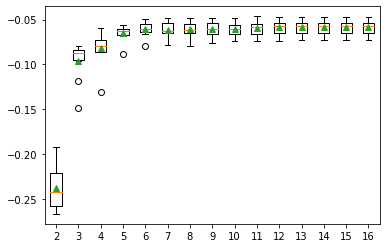

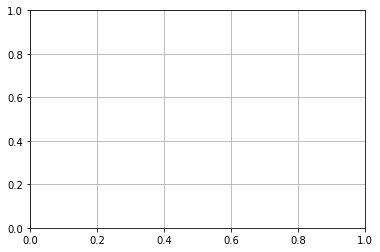

In [ ]:
# Use LinearRegression for regression, DecisionTreeRegressor for feature selection
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor



from sklearn.pipeline import Pipeline
from matplotlib import pyplot

n_features_to_select = [2, len(x_cols)]

# get the dataset
def get_dataset(X, Y):
	X, y = X, Y
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(n_features_to_select[0], n_features_to_select[1]):
		#rfe = RFE(estimator=LinearRegression(), n_features_to_select=i)
		rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=i)
		model = LinearRegression()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = KFold(n_splits=10, shuffle=False, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset(X, Y)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()
pyplot.grid()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


>2 -0.228 (0.032)
>3 -0.142 (0.027)
>4 -0.069 (0.008)
>5 -0.065 (0.010)
>6 -0.063 (0.009)
>7 -0.058 (0.008)
>8 -0.058 (0.008)
>9 -0.058 (0.009)
>10 -0.058 (0.009)
>11 -0.058 (0.008)
>12 -0.058 (0.008)
>13 -0.058 (0.008)
>14 -0.058 (0.008)
>15 -0.058 (0.008)
>16 -0.058 (0.008)


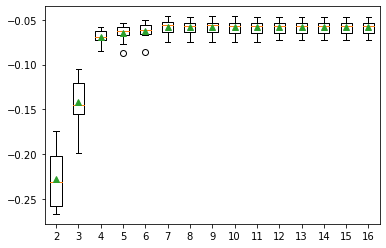

In [ ]:
# Use LinearRegression for regression, LinearRegression for feature selection
# DecisionTreeRegressor for feature selection ??? TODO
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor



from sklearn.pipeline import Pipeline
from matplotlib import pyplot

n_features_to_select = [2, len(x_cols)]

# get the dataset
def get_dataset(X, Y):
	X, y = X, Y
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(n_features_to_select[0], n_features_to_select[1]):
		#rfe = RFE(estimator=LinearRegression(), n_features_to_select=i)
		rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=i)
		model = LinearRegression()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = KFold(n_splits=10, shuffle=False, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset(X, Y)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()
pyplot.grid()

In [ ]:
import sklearn.metrics as skmetrics
sorted(skmetrics.SCORERS.keys())


['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

## Q5. Create a column where cpu_utilization < 20 is 0 and cpu_utilization >= 20 as 1. Using this newly created column build a logistic regression. Commment on the evaluation of the model.

In [ ]:
print(X.shape, Y.shape)
print(data_cols, '\n', x_cols)
print(type(X))

In [ ]:
target_threshold = target_transformer.transform([[20]])
target_threshold = target_threshold[0]

In [ ]:
f = lambda x: x>target_threshold
Y_cat = f(Y)*1


In [ ]:
_=plt.hist(Y)

In [ ]:
_= plt.hist(Y_cat)

In [ ]:
# Get orignal target w/o transformation from df
def get_target(df, systemId_selected, numerical_transform_cols):
  if systemId_selected[0] == 'All':
    df_tmp = df[numerical_transform_cols]
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]
  return df_tmp.values

y_real = get_target(df, SYSTEM_ID_SELECTED, 'cpu_utilization' )
#_= plt.hist(y_real)

f1 = lambda x: x>20
y_real_cat = f1(y_real)*1
_= plt.hist(y_real_cat)


>2 0.873 (0.011)
>3 0.917 (0.010)
>4 0.927 (0.010)
>5 0.931 (0.011)
>6 0.933 (0.011)
>7 0.934 (0.010)
>8 0.934 (0.009)
>9 0.934 (0.009)
>10 0.934 (0.009)
>11 0.935 (0.010)
>12 0.936 (0.010)
>13 0.936 (0.010)
>14 0.935 (0.010)
>15 0.936 (0.009)
>16 0.936 (0.009)


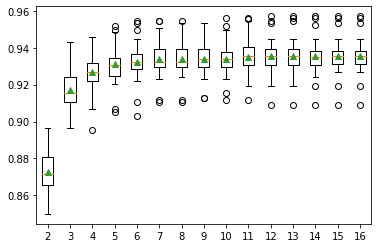

In [ ]:
# Use LogisticRegression for classification, DecisionTreeClassifier for feature selection

# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from matplotlib import pyplot

n_features_to_select = [2, len(x_cols)]

# get the dataset
def get_dataset(X, Y):
	X, y = X, Y
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(n_features_to_select[0], n_features_to_select[1]):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = LogisticRegression()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset(X, Y_cat)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Q6. Fit a simple decision tree regressor to this data. Comment about the fit of the model

>2 0.818 (0.013)
>3 0.888 (0.012)
>4 0.902 (0.012)
>5 0.905 (0.011)
>6 0.910 (0.009)
>7 0.911 (0.012)
>8 0.911 (0.012)
>9 0.907 (0.011)
>10 0.906 (0.012)
>11 0.908 (0.011)
>12 0.907 (0.010)
>13 0.908 (0.009)
>14 0.906 (0.009)
>15 0.905 (0.010)
>16 0.906 (0.010)


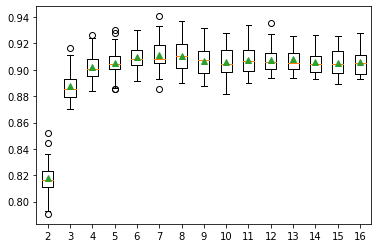

In [ ]:
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

n_features_to_select = [2, len(x_cols)]

# get the dataset
def get_dataset(X, Y):
	X, y = X, Y
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(n_features_to_select[0], n_features_to_select[1]):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = DecisionTreeClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset(X, Y_cat)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Q7. Fit a Random forest regressor. Compare this with simple dicision tree. If Random forest is better then why

>2 0.853 (0.011)
>3 0.917 (0.010)
>4 0.929 (0.009)
>5 0.932 (0.009)
>6 0.936 (0.009)
>7 0.939 (0.008)
>8 0.940 (0.007)
>9 0.940 (0.007)
>10 0.940 (0.008)
>11 0.940 (0.008)
>12 0.941 (0.008)
>13 0.940 (0.008)
>14 0.940 (0.008)
>15 0.941 (0.009)
>16 0.940 (0.008)


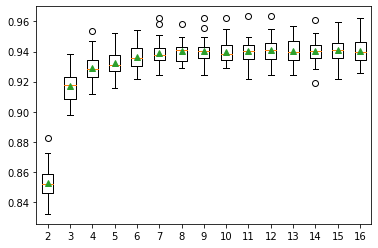

In [ ]:
# Use RandomForestClassifier for classification, DecisionTreeClassifier for feature selection
# TODO: add f1-score for biased classification
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from matplotlib import pyplot

n_features_to_select = [2, len(x_cols)]

# get the dataset
def get_dataset(X, Y):
	X, y = X, Y
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(n_features_to_select[0], n_features_to_select[1]):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = RandomForestClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset(X, Y_cat)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Q8. How do improve the accuracy of Random forest regressor

In [ ]:
df.head()

## Q9. Cluster the input variables using KMeans and GMM.
       
1.   Draw the contour plots
2.   Explain the hyper-parameters you choose and why?



In [ ]:
df.plot(subplots=True)